We are going to apply MCMC to reproduce the analysis in the paper
"Measurements of Omega and Lambda from 42 High-Redshift Supernovae"
by Perlmutter et al. 1999
https://arxiv.org/abs/astro-ph/9812133
which led to the Nobel Prize in Physics in 2011.

What this paper does (for our purposes) is measures the brightnesses of 42 supernovae, and the redshifts of the host galaxies.  This correspondence between the redshift and "luminosity distance" (the distance you infer from the decrease in brightness) puts constraints on the cosmological model.  These supernovae were enough to distinguish between different cosmological models, and showed that Dark Energy is required to fit the data.

The LaTeX version of the paper has the data in two tables (Table 1 and Table 2).  I edited out the latex code and put the data in a file called "p99-data.txt".  It looks like this:
```
# SNname z       sigma_z m_x_peak sigma_x_peak A_x   K_bx   m_b_peak  m_b_eff sigma_m_b_eff
1992bi   0.458   0.001   22.12    0.10         0.03  -0.72  22.81     23.11   0.46
1994F    0.354   0.001   22.08    0.10         0.11  -0.58  22.55     22.38   0.33
1994G    0.425   0.001   21.52    0.21         0.03  -0.68  22.17     22.13   0.49
...
```

Where "SNname" is the name of the supernova, "z" is the redshift (with "sigma_z" its uncertainty).  We are going to ignore most of the other columns, and focus on the last ones, "m_b_eff" and "sigma_m_b_eff", which are the corrected brightnesses of the supernova, in weird astronomer units of "magnitudes".

I write a little function to parse the data and convert them to Julia arrays.  You don't need to understand this.

In [1]:
function read_data()
    open("p99-data.txt", "r") do io
        line = readline(io)
        # drop "#"
        if line[1] == '#'
            line = line[2:end]
        end
        words = split(line)
        ncols = length(words)
        lines = readlines(io)
        nlines = length(lines)
        names = []
        redshift = zeros(nlines)
        m_b_eff = zeros(nlines)
        sigma_m_b_eff = zeros(nlines)
        for i in 1:nlines
            # HACK --- I'm hard-coding which columns contain which data
            words = split(lines[i])
            push!(names, words[1])
            redshift[i] = parse(Float64, words[2])
            m_b_eff[i] = parse(Float64, words[9])
            sigma_m_b_eff[i] = parse(Float64, words[10])
        end
        return names, redshift, m_b_eff, sigma_m_b_eff
    end
end;

We'll call this function to read the data.

In [2]:
(name, z, m, merr) = read_data();

Let's have a quick look at the data.

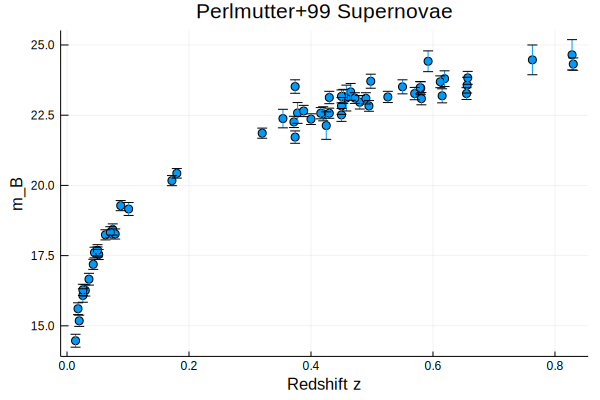

In [3]:
using Plots
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")

Note that in magnitudes, larger values mean fainter objects, so this shows how supernovae in higher-redshift galaxies are fainter.  Also notice that the error bars become larger for fainter objects.

Next, we're going to define a bunch of functions that we need to write our generative model that connects parameters of the model (how much stuff is in the univers) with the observables (how bright supernovae are).  You don't need to understand these if you don't care about cosmology!

In [4]:
using QuadGK
# Distance functions for a Flat Lambda CDM cosmology model.
# These functions are taken from astropy.cosmology, specialized for the FlatLambdaCDM model.

# A minimal Flat Lambda CDM model
mutable struct LCDM
    # Omega-matter
    Om0::Float64
    # Omega-dark-energy
    Ode0::Float64
    # H0
    hubble_distance::Float64
end

function luminosity_distance(cosmology, z)
    return (1. + z) * comoving_transverse_distance(cosmology, z)
end
function comoving_transverse_distance(cosmology, z)
    return comoving_transverse_distance_z1z2(cosmology, 0., z)
end
function comoving_transverse_distance_z1z2(cosmology, z1, z2)
    # HERE we're assuming Ok0=0
    # (Omega curvature; the effective curvature density/critical density at z=0)
    return comoving_distance_z1z2(cosmology, z1, z2)
end
function comoving_distance_z1z2(cosmology, z1, z2)
    integral_comoving_distance_z1z2(cosmology, z1, z2)
end
function integral_comoving_distance_z1z2(cosmology, z1, z2)
    function flcdm_inv_efunc_norel(z)
        Om0 = cosmology.Om0
        Ode0 = cosmology.Ode0
        return ((1. + z)^3 * Om0 + Ode0) ^ -0.5
    end
    # HERE we turn off relativistic species (Tcmb=0)
    (integral,error) = quadgk(flcdm_inv_efunc_norel, z1, z2)
    return cosmology.hubble_distance * integral
end;

# Perlmutter+ define D_L = H_0 d_L; you could drop the factor of hubble_distance
# from luminosity_distance here if you wanted.  It will all just get folded into the
# M_B offset.
function distance_modulus(universe, z)
    5. * log10.(luminosity_distance(universe, z) / 10.)
end;

This "luminosity distance" function is our model of how supernovae get fainter.  There is an overall offset (effectively, how bright a supernova would be at a fixed distance), which we also need to fit.  We don't really care about this value in this analysis, but we need to consider our uncertainty on its value in our analysis.

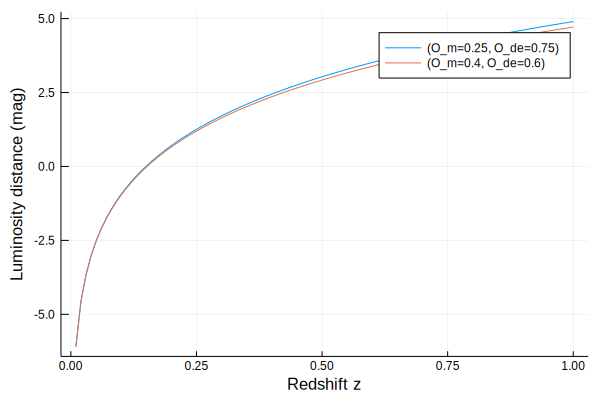

In [5]:
zgrid = 0.01:0.01:1.
# We use these functions by creating a "LCDM" object, which holds the parameters, and then calling the
# "distance_modulus" function with those parameters and a redshift z.
universe = LCDM(0.25, 0.75, 60.)
DL = map(z->distance_modulus(universe, z), zgrid)
plot(zgrid, DL, xlabel="Redshift z", ylabel="Luminosity distance (mag)", label="(O_m=0.25, O_de=0.75)")

universe = LCDM(0.4, 0.6, 60.)
DL = map(z->distance_modulus(universe, z), zgrid)
plot!(zgrid, DL, label="(O_m=0.4, O_de=0.6)")

Finally, we're ready to write our likelihood function that, given our measurements (magnitudes of supernovae), plus the redshifts of those supernovae, plus our parameters: M, the overall brightness scaling (which we don't really care about) and Omatter, the amount of matter in the universe, which we care a great deal about!

We're assuming a flat cosmology here, so O_matter plus O_dark_energy equals 1.

In [6]:
function supernova_log_likelihood(z, m, merr, M, Omatter)
    universe = LCDM(Omatter, 1.0-Omatter, 60.)
    DL = map(zi->distance_modulus(universe, zi), z)
    # Predicted brightness of supernovae:
    m_pred = M .+ DL
    # Gaussian measurement model:
    return -0.5 * sum(@. (m - m_pred)^2 / merr^2)
end;

Next, we're going to impose flat priors over the allow range of parameters:

In [7]:
function supernova_log_posterior(X)
    (M, Omatter) = X
    if (Omatter < 0) || (Omatter > 1)
        return -Inf
    end
    return supernova_log_likelihood(z, m, merr, M, Omatter)
end;

Now we can cheat and map out the posterior probability space on a grid!

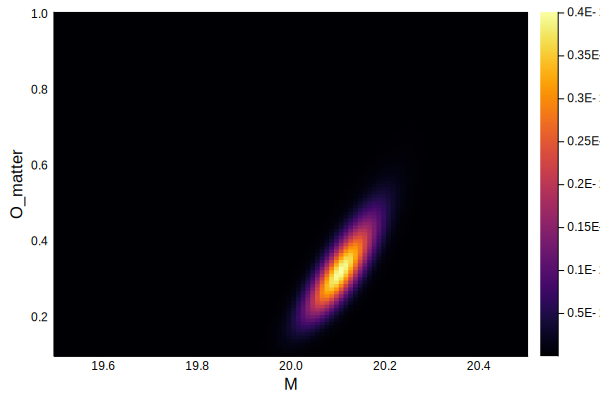

In [8]:
Mlo,Mhi = 19.5, 20.5
Olo,Ohi = 0.1, 1.0
MM = range(Mlo, stop=Mhi, length=100)
OO = range(Olo, stop=Ohi, length=100)
LL = zeros((length(MM), length(OO)))
for i in 1:length(MM)
    for j in 1:length(OO)
        LL[i, j] = supernova_log_posterior((MM[j], OO[i]))
    end
end
heatmap(MM, OO, exp.(LL), xlabel="M", ylabel="O_matter")

Which shows you that Omega_matter is definitely not 1 --- which means we're not in a matter-dominated universe -- there must be dark energy!  (At least, *assuming the Flat Lambda-CDM model*, O_dark_energy is definitely not zero.)

Now let's use MCMC to get this same result.

In order to understand the proposal distribution step sizes, I'm going to use an MCMC variant where we randomly select a single dimension to jump in, and track acceptance rates independently.

In [9]:
function mcmc_oneparam(log_prob_func, params, proposal_func, nsteps)
    chain = []
    logprob = log_prob_func(params)

    nparams = length(params)
    # how many times we accepted a move
    naccepts = zeros(nparams)
    ntries   = zeros(nparams)

    for i in 1:nsteps
        # which parameter are we going to step in?
        pindex = rand(1:nparams)
        ntries[pindex] += 1
        p_old = params[pindex]
        # propose new parameter values
        p_new = proposal_func(pindex, p_old)
        params[pindex] = p_new
        # compute log-posterior at new parameters
        logprob_new = log_prob_func(params)

        if (exp(logprob_new - logprob) >= rand(Float64))
            naccepts[pindex] += 1
            logprob = logprob_new
        else
            params[pindex] = p_old
        end
        append!(chain, params)
    end
    # append! makes "chain" a 1-d vector; reshape to a matrix
    chain = reshape(chain, (2,Int64(length(chain)/length(params))))';
    println("Acceptance rates:")
    for i in 1:nparams
        println("  parameter", i, ": ", 100. * naccepts[i]/ntries[i], "%")
    end
    return chain
end;

In [10]:
jump_sizes = [0.1, 0.1]
function proposal_oneparam(pindex, p_old)
    return p_old + randn() * jump_sizes[pindex]
end;

In [11]:
chain = mcmc_oneparam(supernova_log_posterior, [20., 0.3], proposal_oneparam, 10000);

Acceptance rates:
  parameter1: 33.32672874975233%
  parameter2: 50.4340803553402%


We could use this report of the acceptance rates to tune the "jump_sizes" above.

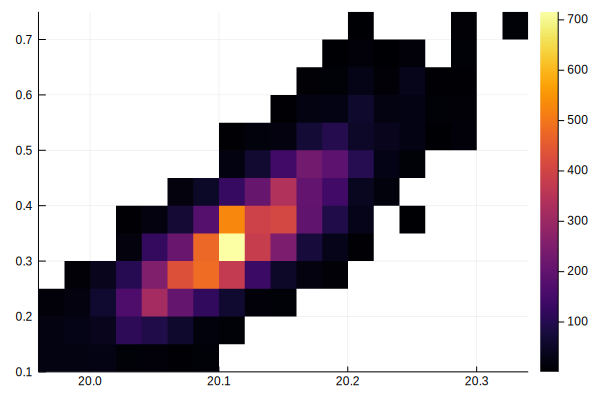

In [12]:
histogram2d(chain[:,1], chain[:,2])

And just for kicks, here's a more "vanilla" MCMC function that moves all parameters at once.

In [44]:
function mcmc(log_prob_func, params, proposal_func, nsteps)
    chain = []
    logprobs = []
    logprob = log_prob_func(params)
    # how many times we accepted a move
    naccepts = 0
    for i in 1:nsteps
        # propose new parameter values
        params_new = proposal_func(params)
        # compute log-posterior at new parameters
        logprob_new = log_prob_func(params_new)
        if (exp(logprob_new - logprob) >= rand(Float64))
            naccepts += 1
            logprob = logprob_new
            params = params_new
        end
        append!(chain, params)
        append!(logprobs, logprob)
    end
    # append! makes "chain" a 1-d vector; reshape to a matrix
    chain = reshape(chain, (2,Int64(length(chain)/length(params))))';
    println("Acceptance rate: ", 100. * naccepts/nsteps, "%")
    return chain, logprobs
end;

In [14]:
jump_sizes = [0.1, 0.1]
function proposal_vanilla(p_old)
    return p_old .+ randn(length(p_old)) .* jump_sizes
end;

In [45]:
chain,logprobs = mcmc(supernova_log_posterior, [20., 0.3], proposal_vanilla, 100000);

Acceptance rate: 23.829%


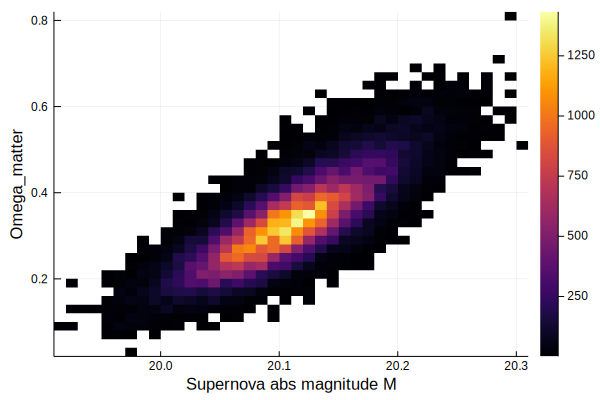

In [52]:
histogram2d(chain[:,1], chain[:,2], xlabel="Supernova abs magnitude M", ylabel="Omega_matter")

Let's summarize our constrain on O_matter, and also show a sampling of our fit results in the data space.

We must drop some initial samples to reduce the effect of initial conditions; this is called "burn-in".

In [57]:
nsamples = size(chain)[1]
goodchain = chain[10001:nsamples, :]
goodlogprobs = logprobs[10001:nsamples]
omchain = goodchain[:,2];
besti = argmax(goodlogprobs)
bestparams = goodchain[besti,:];

In [18]:
using Statistics
omean,ostd = mean(omchain), std(omchain)
omed = median(omchain)
oq = quantile(omchain, [0.16, 0.84])
odif = (oq[2]-oq[1])/2.;

In [19]:
using Printf
@printf("Omega_matter: %.3f +- %.3f (using mean)\n", omean,ostd)
@printf("Omega_matter: %.3f +- %.3f (using median)\n", omed,odif)

Omega_matter: 0.335 +- 0.086 (using mean)
Omega_matter: 0.331 +- 0.086 (using median)


This *should* correspond with the result in Perlmutter et al 1999, Table 3, but is off by a bit: they report 0.29 +- 0.08.  I am certain it's my error, but I'm not sure where!

Finally, let's examine whether this model is actually a good fit to the data!

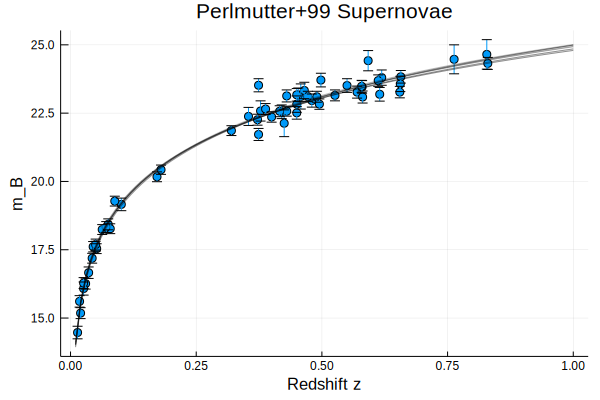

In [61]:
plot(z, m, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="m_B",
title="Perlmutter+99 Supernovae")
# Select some random samples from the chain and plot their model predictions
I = rand(1:length(goodchain[:,1]), 10);
for i in I
    M,om = goodchain[i,:]
    universe = LCDM(om, 1.0-om, 60.)
    DL = map(z->distance_modulus(universe, z), zgrid)
    m_pred = DL .+ M
    plot!(zgrid, m_pred, label="", color="black", alpha=0.25)
end;
plot!()

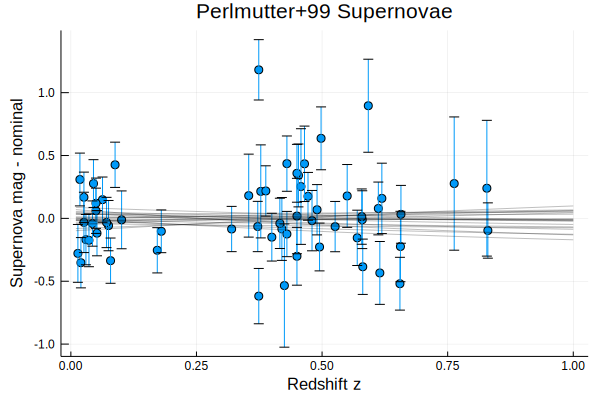

In [63]:
# Let's compare to the maximum-likelihood values found
M,om = bestparams
universe = LCDM(om, 1.0-om, 60.)
DL = map(z->distance_modulus(universe, z), zgrid)
m_nomgrid = DL .+ M
DL = map(z->distance_modulus(universe, z), z)
m_nom = DL .+ M

plot(z, m-m_nom, yerr=merr, seriestype=:scatter, label="", xlabel="Redshift z", ylabel="Supernova mag - nominal",
title="Perlmutter+99 Supernovae")
# Select some random samples from the chain and plot their model predictions
I = rand(1:length(goodchain[:,1]), 20);
for i in I
    M,om = goodchain[i,:]
    universe = LCDM(om, 1.0-om, 60.)
    DL = map(z->distance_modulus(universe, z), zgrid)
    m_pred = DL .+ M
    plot!(zgrid, m_pred - m_nomgrid, label="", color="black", alpha=0.25)
end;
plot!()

Looks okay!